# НЕЙРОННЫЕ СЕТИ

# Распознавание объектов на изображениях из набора данных CIFAR-10


**Набор данных CIFAR-10** представляет собой набор изображений, которые обычно используются для обучения алгоритмов машинного обучения и компьютерного зрения. Набор данных CIFAR-10 содержит 60 000 цветных изображений размером 32x32 в 10 различных классах. В наборе содержится по 6000 изображений каждого класса.

Загрузим необходимые библиотеки: `keras` для работы с нейросетями, `numpy` для научных вычислений, `matplotlib` для построения графиков. 

* В Keras, вы собираете слои (layers) для построения моделей (models). Модель это (обычно) граф слоев. Наиболее распространенным видом модели является стек слоев Sequential. Так как наша нейронная сеть будет делать ряд последовательных преобразований входных данных, нам нужен тип нейронных сетей Sequential: импортируем его из раздела `keras.models`.

* Типы преобразований, с которыми мы будем работать: плотный слой Dense, активация Activation, слой регуляризации Dropout, сверточный слой Conv2D, слой подвыборки MaxPooling2D, преобразование картинки в длинный вектор Flatten. Каждое преобразование будет отдельным слоем в последовательной модели, поэтому импортируем их из `keras.layers`

In [1]:
# Импортируем сам keras
import keras
# Последовательный тип модели
from keras.models import Sequential
# Импортируем полносвязный слой, слои активации и слой, 
# превращающий картинку в вектор
from keras.layers import Dense, Activation, Flatten
# Импортируем сверточный слой, слои, фильтрующий максимальные значения из 
# входных данных, слой "выключающий часть нейронов"
from keras.layers import Conv2D, MaxPooling2D, Dropout

# Импортируем датасеты, чтобы вытащить оттуда нужные нам данные
import keras.datasets

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

# Эти библиотеки отключают лишние предупреждения от библиотек, в частности,
# tensorflow, чтобы не засорять вывод наших результатов
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image

from google.colab import files

Датасет уже лежит в библиотеке `keras`, загрузим его и посмотрим на содержание выборки.

In [2]:
# Импортируем модуль датасета CIFAR10
from keras.datasets import cifar10

## Подготовка данных

**Загружаем данные**

In [3]:
# Выгрузим тренировочные и тестовые данные при помощи метода load_data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [4]:
X_train.shape, Y_train.shape, X_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3))

In [5]:
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

**Просмотр примеров данных**

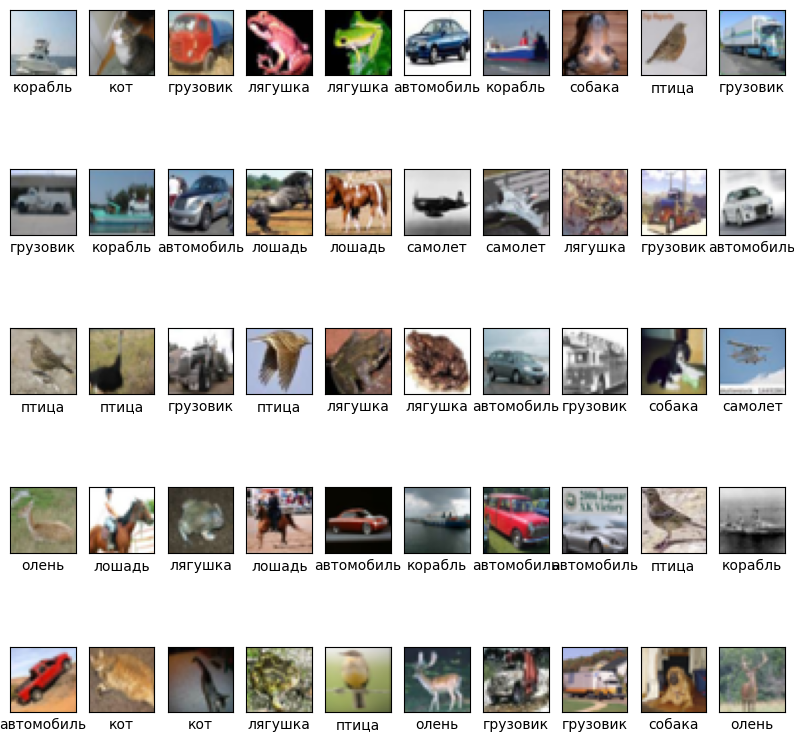

In [6]:
plt.figure(figsize=(10,10))
for i in range(100,150):
    plt.subplot(5,10,i-100+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(classes[Y_train[i][0]])

**Нормализация значений на [0,1] и перевод целевой переменной в one-hot формат**

Нейронные сети более капризны по сравнению с линейными моделями и моделями на основе решающих деревьев. 

Поэтому им нужна предварительная нормализация данных: чтобы значения всех входных признаков лежали в интервале от $0$ до $1$. 

При этом каждый пиксель картинки представлен в виде целого числа от $0$ до $255$ (для черно-белых картинок) и в виде набора из трех целых чисел от $0$ до $255$ для цветных.

Поэтому нормализацию картинки можно произвести простым делением на $255$.


**Нормализуем данные**

In [7]:
x_train = X_train / 255
x_test = X_test / 255

In [8]:
x_train[0]

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

Еще нейронной сети нужно значение выходной переменной в one-hot формате.

Напомним, что такое **one-hot encoding**. 

Сейчас наша целевая переменная - классы от $0$ до $9$, то есть $10$ классов. Для каждой картинки наша сеть будет предсказывать вероятность принадлежности к каждому из этих десяти классов. 

Соответственно, истинным значением целевой переменной будет вектор длины $10$, состоящий из $0$ с одной $1$ на месте номера класса, к которому принадлежит картинка.

Это делаем функцией из `keras` `keras.utils.to_categorical`, которая принимает на вход исходный вектор значений выходной переменной и число классов.

**Преобразуем правильные ответы в формат one hot encoding**

In [9]:
y_train = utils.to_categorical(Y_train, 10)
y_test = utils.to_categorical(Y_test, 10)

In [10]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## Создаем нейронную сеть

In [11]:
# Создаем последовательную модель
model = Sequential()
# Первый сверточный слой
model.add(Conv2D(filters=32,  kernel_size=(3, 3), padding='same',
                        input_shape=(32, 32, 3), activation='relu'))
# Второй сверточный слой
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Третий сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu'))
# Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu'))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
model.add(Dense(512, activation='relu'))
# Слой регуляризации Dropout
model.add(Dropout(0.5))
# Выходной полносвязный слой
model.add(Dense(10, activation='softmax'))

**Печатаем информацию о сети**

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                        

**Компилируем модель**

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [14]:
history = model.fit(x_train, y_train,
              batch_size=16,
              epochs=15,
              validation_split=0.1,
              verbose=1)

Epoch 1/15
2813/2813 [==============================] - 27s 6ms/step - loss: 1.5448 - accuracy: 0.4334 - val_loss: 1.1874 - val_accuracy: 0.5712
Epoch 2/15
2813/2813 [==============================] - 14s 5ms/step - loss: 1.1730 - accuracy: 0.5816 - val_loss: 0.9964 - val_accuracy: 0.6516
Epoch 3/15
2813/2813 [==============================] - 15s 5ms/step - loss: 1.0359 - accuracy: 0.6364 - val_loss: 0.8560 - val_accuracy: 0.7082
Epoch 4/15
2813/2813 [==============================] - 16s 6ms/step - loss: 0.9526 - accuracy: 0.6636 - val_loss: 0.8075 - val_accuracy: 0.7108
Epoch 5/15
2813/2813 [==============================] - 15s 5ms/step - loss: 0.8976 - accuracy: 0.6853 - val_loss: 0.7595 - val_accuracy: 0.7286
Epoch 6/15
2813/2813 [==============================] - 15s 5ms/step - loss: 0.8557 - accuracy: 0.6996 - val_loss: 0.7784 - val_accuracy: 0.7262
Epoch 7/15
2813/2813 [==============================] - 14s 5ms/step - loss: 0.8209 - accuracy: 0.7126 - val_loss: 0.7480 - val_ac

## Оцениваем качетсво обучения сети

In [15]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(x_test, y_test, verbose=1)


313/313 [==============================] - 1s 3ms/step - loss: 0.7161 - accuracy: 0.7577


In [16]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 75.77


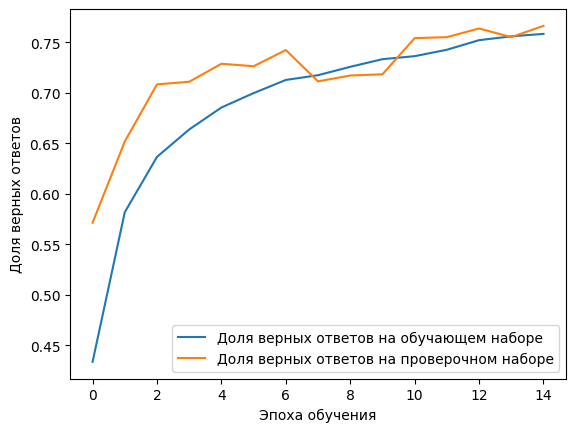

In [17]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

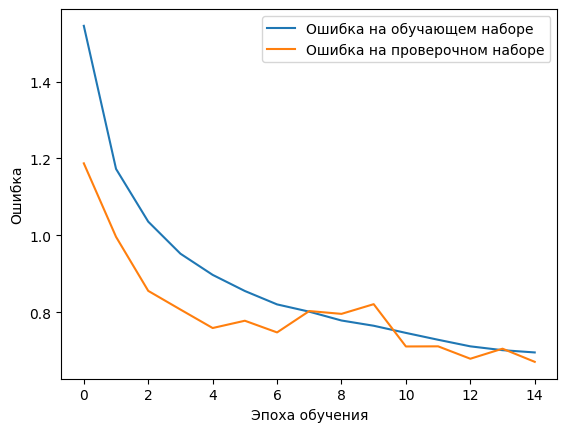

In [18]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Результат

- [Лучшие результаты нейронных сетей](https://benchmarks.ai/cifar-10) для этого набора данных, разработанные людьми показывают 99%.

## Сохраняем обученную нейронную сеть

In [19]:
model.save("cifar10_model.h5")

## Применяем сеть для распознавания объектов на изображениях

**Просмотр изображения из набора данных для тестирования**

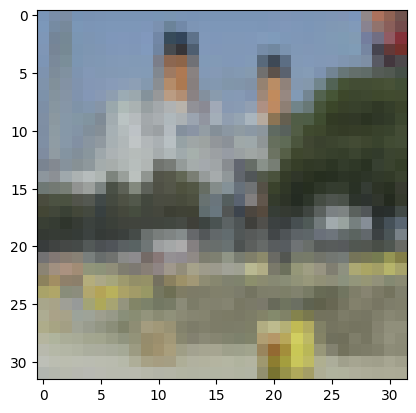

In [20]:
index=4000
plt.imshow(X_test[index])
plt.show()

**Преобразование тестового изображения**

In [21]:
x = x_test[index]
x = np.expand_dims(x, axis=0)

**Запуск распознавания**

In [22]:
prediction = model.predict(x)

1/1 [==============================] - 0s 194ms/step


**Печатаем результаты распознавания**

In [23]:
print(prediction)

[[0.08667651 0.00680744 0.07442483 0.06971019 0.43020752 0.03130555
  0.0087351  0.1842592  0.02905614 0.07881747]]


**Преобразуем результаты из формата one hot encoding**

In [24]:
prediction = np.argmax(prediction)
print(classes[prediction])

олень


**Печатаем правильный ответ**

In [25]:
print(classes[Y_test[index][0]])

корабль


## Распознаем дополнительное изображение

In [26]:
files.upload()

{}

**Смотрим загруженную картинку**

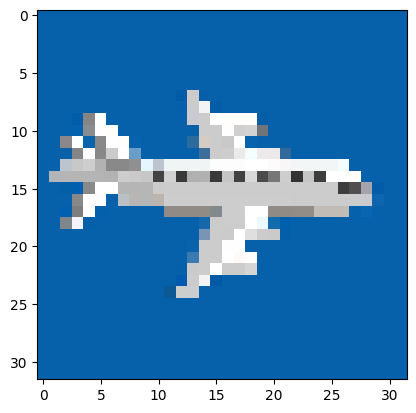

In [27]:
img_path = '/content/56000207-pixel-art-illustration-of-airplane-airline-service-flying-air-passenger-transport.jpg'
img = image.load_img(img_path, target_size=(32, 32))
plt.imshow(img)
plt.show()

**Преобразуем картинку в массив для распознавания**

In [28]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

**Запускаем распознавание**

In [29]:
prediction = model.predict(x)

1/1 [==============================] - 0s 21ms/step


In [30]:
prediction

array([[9.4814485e-01, 5.7850384e-06, 1.5530439e-05, 3.9090722e-07,
        1.4353317e-08, 6.2391681e-10, 7.3243775e-08, 4.3198972e-11,
        5.1833048e-02, 3.1570249e-07]], dtype=float32)

In [31]:
prediction = np.argmax(prediction)
prediction

0

In [32]:
print(classes[prediction])

самолет


## Предварительно обученная сеть VGG16

**VGG** - семейство существующих архитектур нейросетей, которые демонстрируют одни из лучших результатов в задачах выделения признаков из картинок.

Пример архитектуры VGG-16

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16.png" width="500">


In [33]:
from tensorflow.keras.applications.vgg16 import VGG16

In [34]:
# загружам предварительно обученную нейронную сеть
net = VGG16(weights='imagenet', 
                    include_top=False, 
                    input_shape=(32, 32, 3))
net.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


ImageNet — это набор данных из более чем 15 миллионов размеченых изображений с высоким разрешением, принадлежащих примерно к 22 000 категориям. Изображения были собраны из Интернета и промаркированы людьми с помощью краудсорсингового инструмента Amazon Mechanical Turk. Начиная с 2010 года в рамках Pascal Visual Object Challenge проводится ежегодное соревнование под названием ImageNet Large-Scale Visual Recognition Challenge (ILSVRC). ILSVRC использует подмножество ImageNet с примерно 1000 изображений в каждой из 1000 категорий. Всего имеется примерно 1.2 миллиона обучающих изображений, 50 000 проверочных изображений и 150 000 тестовых изображений. ImageNet состоит из изображений с переменным разрешением. Поэтому изображения были уменьшены до фиксированного разрешения 256×256. Учитывая прямоугольное изображение, изображение масштабируется и вырезается центральный участок 256 × 256 из полученного изображения.

In [35]:
net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [36]:
model = Sequential()
# Добавляем модель VGG16 в сеть как слой
model.add(net)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [39]:
history = model.fit(x_train, y_train,
              batch_size=16,
              epochs=15,
              validation_split=0.1,
              verbose=1)

Epoch 1/15
2813/2813 [==============================] - 25s 8ms/step - loss: 1.4546 - accuracy: 0.4884 - val_loss: 1.2342 - val_accuracy: 0.5696
Epoch 2/15
2813/2813 [==============================] - 23s 8ms/step - loss: 1.2945 - accuracy: 0.5444 - val_loss: 1.1654 - val_accuracy: 0.5898
Epoch 3/15
2813/2813 [==============================] - 22s 8ms/step - loss: 1.2409 - accuracy: 0.5623 - val_loss: 1.1508 - val_accuracy: 0.5940
Epoch 4/15
2813/2813 [==============================] - 22s 8ms/step - loss: 1.2084 - accuracy: 0.5765 - val_loss: 1.1265 - val_accuracy: 0.6030
Epoch 5/15
2813/2813 [==============================] - 22s 8ms/step - loss: 1.1804 - accuracy: 0.5864 - val_loss: 1.1163 - val_accuracy: 0.6082
Epoch 6/15
2813/2813 [==============================] - 22s 8ms/step - loss: 1.1583 - accuracy: 0.5941 - val_loss: 1.1079 - val_accuracy: 0.6116
Epoch 7/15
2813/2813 [==============================] - 23s 8ms/step - loss: 1.1363 - accuracy: 0.6008 - val_loss: 1.0974 - val_ac

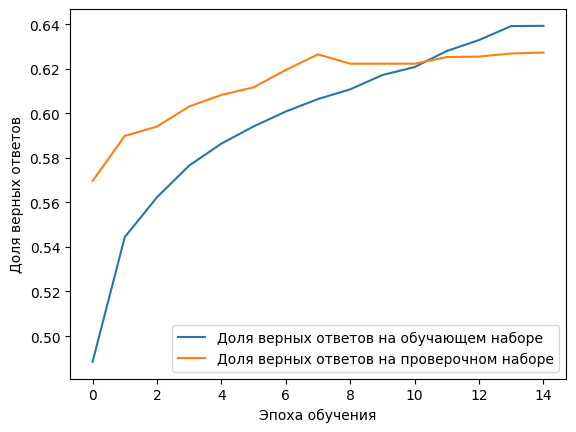

In [40]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [41]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(x_test, y_test, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

313/313 [==============================] - 3s 9ms/step - loss: 1.1129 - accuracy: 0.6175
Доля верных ответов на тестовых данных, в процентах: 61.75


**Почему качество загруженной нейроной сети такое низкое? С чем это связано? Что можно сделать, чтобы улучшить нейронную сеть?**